In [16]:
import jax
import jax.numpy as jnp                # JAX NumPy
from jax import random


import flax
from flax import linen as nn           # The Linen API
from flax.training import train_state  # Useful dataclass to keep train state

import numpy as np                     # Ordinary NumPy
import optax                           # Optimizers

from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt

AttributeError: module 'numpy.linalg._umath_linalg' has no attribute '_ilp64'

In [ ]:
random.PRNGKey(2)

The number of data points in the dataset is 1797
The image resolution is 8x8


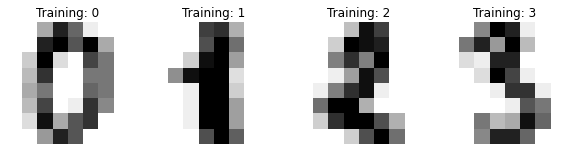

In [2]:
# Download and explore the dataset
from sklearn import datasets
digits = datasets.load_digits()

# Information about the dataset
npoints, xres, yres = digits.images.shape
print('The number of data points in the dataset is {:d}'.format(npoints))
print('The image resolution is {:d}x{:d}'.format(xres, yres))

# Visualise 
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)

In [3]:
# Split data into 50% train and 50% test subsets
X_train, X_test, y_train, y_test = train_test_split(digits.images, digits.target, test_size=0.5, shuffle=False)

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [4]:
# Create datasets
def get_datasets(X_train, X_test, y_train, y_test):

  train_ds = {'image': jnp.float32(X_train), 'label': y_train}
  test_ds = {'image': jnp.float32(X_test), 'label': y_test}
    
  return train_ds, test_ds

train_ds, test_ds = get_datasets(X_train, X_test, y_train, y_test)

In [5]:
# Model
class CNN(nn.Module):
  """A simple CNN model."""

  @nn.compact
  def __call__(self, x, is_training):
    dropout_rng = self.make_rng('dropout')
    x = nn.Conv(features=16, kernel_size=(3, 3), padding='same')(x)
    x = nn.relu(x)
    x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=32, kernel_size=(3, 3), padding='same')(x)
    x = nn.relu(x)
    x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=64, kernel_size=(3, 3), padding='same')(x)
    x = nn.relu(x)
    x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Dropout(0.2, deterministic=not is_training)(x)
    x = x.reshape((x.shape[0], -1))  # flatten
    x = nn.Dense(features=128)(x)
    x = nn.relu(x)
    x = nn.Dense(features=10)(x)
    x = nn.log_softmax(x)
    
    return x

In [6]:
# Loss
def cross_entropy_loss(*, logits, labels):
  one_hot_labels = jax.nn.one_hot(labels, num_classes=10)
  return -jnp.mean(jnp.sum(one_hot_labels * logits, axis=-1))

In [7]:
# Metric
def compute_metrics(*, logits, labels):
  loss = cross_entropy_loss(logits=logits, labels=labels)
  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  metrics = {
      'loss': loss,
      'accuracy': accuracy,
  }
  return metrics

In [8]:
# Training state
def create_train_state(rng, learning_rate):
  """Creates initial `TrainState`."""
  cnn = CNN()
  params = cnn.init(rng, jnp.ones([1, 8, 8, 1]), is_training=True)['params']
  tx = optax.adam(learning_rate)
  return train_state.TrainState.create(
      apply_fn=cnn.apply, params=params, tx=tx)

In [9]:
# Training step
@jax.jit
def train_step(state, batch):
  """Train for a single step."""
  def loss_fn(params):
    logits = CNN().apply({'params': params}, batch['image'], is_training=True, 
                         rngs={'dropout': random.PRNGKey(2)})
    loss = cross_entropy_loss(logits=logits, labels=batch['label'])
    return loss, logits
  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (_, logits), grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  metrics = compute_metrics(logits=logits, labels=batch['label'])
  return state, metrics

In [10]:
# Evaluation step
@jax.jit
def eval_step(params, batch):
  logits = CNN().apply({'params': params}, batch['image'], is_training=False, rngs={'dropout': random.PRNGKey(2)})
  return compute_metrics(logits=logits, labels=batch['label'])

In [11]:
# Train function
def train_epoch(state, train_ds, batch_size, epoch, rng):
  """Train for a single epoch."""
  train_ds_size = len(train_ds['image'])
  steps_per_epoch = train_ds_size // batch_size

  perms = jax.random.permutation(rng, train_ds_size)
  perms = perms[:steps_per_epoch * batch_size]  # skip incomplete batch
  perms = perms.reshape((steps_per_epoch, batch_size))
  batch_metrics = []
  for perm in perms:
    batch = {k: v[perm, ...] for k, v in train_ds.items()}
    state, metrics = train_step(state, batch)
    batch_metrics.append(metrics)

  # compute mean of metrics across each batch in epoch.
  batch_metrics_np = jax.device_get(batch_metrics)
  epoch_metrics_np = {
      k: np.mean([metrics[k] for metrics in batch_metrics_np])
      for k in batch_metrics_np[0]}

  print('train epoch: %d, loss: %.4f, accuracy: %.2f' % (
      epoch, epoch_metrics_np['loss'], epoch_metrics_np['accuracy'] * 100))

  return state

In [12]:
# Evaluation function
def eval_model(params, test_ds):
  metrics = eval_step(params, test_ds)
  metrics = jax.device_get(metrics)
  summary = jax.tree_map(lambda x: x.item(), metrics)
  return summary['loss'], summary['accuracy']

In [13]:
# Seed randomness
rng = jax.random.PRNGKey(0)
rng, *init_rng = jax.random.split(rng, 3)

In [14]:
# Initialize train state
learning_rate = 1e-3

state = create_train_state({'params': init_rng[0], 'dropout': init_rng[1]}, learning_rate)
del init_rng  # Must not be used anymore.

In [15]:
# Train and evaluate
num_epochs = 100
batch_size = 16
best_state = None
best_test_accuracy = 0

for epoch in range(1, num_epochs + 1):
  # Use a separate PRNG key to permute image data during shuffling
  rng, input_rng = jax.random.split(rng)
  # Run an optimization step over a training batch
  state = train_epoch(state, train_ds, batch_size, epoch, input_rng)
  # Evaluate on the test set after each training epoch
  test_loss, test_accuracy = eval_model(state.params, test_ds)
  print(' test epoch: %d, loss: %.2f, accuracy: %.2f' % (
      epoch, test_loss, test_accuracy * 100))
  if test_accuracy > best_test_accuracy:
        best_state = state

train epoch: 1, loss: 1.8409, accuracy: 43.30
 test epoch: 1, loss: 0.72, accuracy: 84.87
train epoch: 2, loss: 0.4833, accuracy: 86.61
 test epoch: 2, loss: 0.31, accuracy: 91.21
train epoch: 3, loss: 0.2270, accuracy: 92.97
 test epoch: 3, loss: 0.26, accuracy: 91.10
train epoch: 4, loss: 0.1751, accuracy: 94.31
 test epoch: 4, loss: 0.27, accuracy: 90.66
train epoch: 5, loss: 0.0840, accuracy: 98.10
 test epoch: 5, loss: 0.19, accuracy: 93.66
train epoch: 6, loss: 0.0823, accuracy: 97.21
 test epoch: 6, loss: 0.22, accuracy: 91.99
train epoch: 7, loss: 0.0369, accuracy: 99.11
 test epoch: 7, loss: 0.16, accuracy: 94.88
train epoch: 8, loss: 0.0300, accuracy: 99.22
 test epoch: 8, loss: 0.16, accuracy: 94.22
train epoch: 9, loss: 0.0288, accuracy: 99.33
 test epoch: 9, loss: 0.17, accuracy: 95.33
train epoch: 10, loss: 0.0303, accuracy: 99.00
 test epoch: 10, loss: 0.13, accuracy: 96.00
train epoch: 11, loss: 0.0126, accuracy: 99.89
 test epoch: 11, loss: 0.18, accuracy: 94.77
train 

train epoch: 91, loss: 0.0000, accuracy: 100.00
 test epoch: 91, loss: 0.16, accuracy: 96.89
train epoch: 92, loss: 0.0000, accuracy: 100.00
 test epoch: 92, loss: 0.16, accuracy: 96.66
train epoch: 93, loss: 0.0000, accuracy: 100.00
 test epoch: 93, loss: 0.16, accuracy: 97.11
train epoch: 94, loss: 0.0000, accuracy: 100.00
 test epoch: 94, loss: 0.17, accuracy: 96.89
train epoch: 95, loss: 0.0000, accuracy: 100.00
 test epoch: 95, loss: 0.16, accuracy: 97.00
train epoch: 96, loss: 0.0000, accuracy: 100.00
 test epoch: 96, loss: 0.16, accuracy: 96.89
train epoch: 97, loss: 0.0000, accuracy: 100.00
 test epoch: 97, loss: 0.16, accuracy: 96.89
train epoch: 98, loss: 0.0000, accuracy: 100.00
 test epoch: 98, loss: 0.16, accuracy: 96.77
train epoch: 99, loss: 0.0000, accuracy: 100.00
 test epoch: 99, loss: 0.16, accuracy: 96.89
train epoch: 100, loss: 0.0000, accuracy: 100.00
 test epoch: 100, loss: 0.17, accuracy: 96.77


Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        88
           1       0.99      0.93      0.96        91
           2       1.00      1.00      1.00        86
           3       0.99      0.92      0.95        91
           4       1.00      0.92      0.96        92
           5       0.94      1.00      0.97        91
           6       0.98      1.00      0.99        91
           7       0.97      1.00      0.98        89
           8       0.95      0.94      0.95        88
           9       0.88      0.96      0.92        92

    accuracy                           0.97       899
   macro avg       0.97      0.97      0.97       899
weighted avg       0.97      0.97      0.97       899




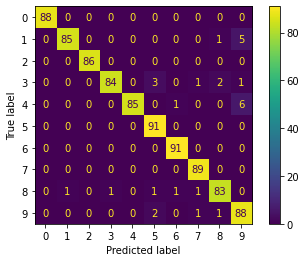

In [16]:
# Analyze the results
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

logits = CNN().apply({'params': best_state.params}, test_ds['image'], is_training=False, 
                     rngs={'dropout': random.PRNGKey(2)})
predicted = jnp.argmax(logits, -1)

print(
    f"Classification report:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
)

class_names = range(10)

# Confusion matrix
cm = confusion_matrix(y_test, predicted, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
disp.plot()
plt.show()

In [17]:
import jax
import jax.numpy as jnp                # JAX NumPy
from jax import random

from flax import linen as nn           # The Linen API
from flax.training import train_state  # Useful dataclass to keep train state

import numpy as np                     # Ordinary NumPy
import optax                           # Optimizers

from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt

# Import database
import idx2numpy

file_X_train = 'mnist/train-images.idx3-ubyte' 
file_y_train = 'mnist/train-labels.idx1-ubyte'
file_X_test = 'mnist/t10k-images.idx3-ubyte' 
file_y_test = 'mnist/t10k-labels.idx1-ubyte' 

X_train = idx2numpy.convert_from_file(file_X_train)
y_train = idx2numpy.convert_from_file(file_y_train)
X_test = idx2numpy.convert_from_file(file_X_test)
y_test = idx2numpy.convert_from_file(file_y_test)

# Information about the dataset
npoints_train, xres, yres = X_train.shape
npoints_test, _, _ = X_test.shape
print('The number of data points in the training dataset is {:d}'.format(npoints_train))
print('The number of data points in the test dataset is {:d}'.format(npoints_test))
print('The image resolution is {:d}x{:d}'.format(xres, yres))

# Split data into 20% and 80% subsets and ignore the 80% dataset
X_train, _, y_train, _ = train_test_split(
    X_train, y_train, test_size=0.8, shuffle=True)
npoints_train, _, _ = X_train.shape
print('The number of data points in the redced training dataset is {:d}'.format(npoints_train))

# Prepare datasets
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Create datasets
def get_datasets(X_train, X_test, y_train, y_test):

  train_ds = {'image': jnp.float32(X_train), 'label': y_train}
  test_ds = {'image': jnp.float32(X_test), 'label': y_test}
    
  return train_ds, test_ds

train_ds, test_ds = get_datasets(X_train, X_test, y_train, y_test)

# Model
class CNN(nn.Module):
  """A simple CNN model."""

  @nn.compact
  def __call__(self, x, is_training):
    dropout_rng = self.make_rng('dropout')
    x = nn.Conv(features=16, kernel_size=(3, 3), padding='same')(x)
    x = nn.relu(x)
    x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=32, kernel_size=(3, 3), padding='same')(x)
    x = nn.relu(x)
    x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=64, kernel_size=(3, 3), padding='same')(x)
    x = nn.relu(x)
    x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Dropout(0.2, deterministic=not is_training)(x)
    x = x.reshape((x.shape[0], -1))  # flatten
    x = nn.Dense(features=128)(x)
    x = nn.relu(x)
    x = nn.Dense(features=10)(x)
    x = nn.log_softmax(x)
    
    return x

# Loss
def cross_entropy_loss(*, logits, labels):
  one_hot_labels = jax.nn.one_hot(labels, num_classes=10)
  return -jnp.mean(jnp.sum(one_hot_labels * logits, axis=-1))

# Metric
def compute_metrics(*, logits, labels):
  loss = cross_entropy_loss(logits=logits, labels=labels)
  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  metrics = {
      'loss': loss,
      'accuracy': accuracy,
  }
  return metrics

# Training state
def create_train_state(rng, learning_rate):
  """Creates initial `TrainState`."""
  cnn = CNN()
  params = cnn.init(rng, jnp.ones([1, xres, yres, 1]), is_training=True)['params']
  tx = optax.adam(learning_rate)
  return train_state.TrainState.create(
      apply_fn=cnn.apply, params=params, tx=tx)

# Training step
@jax.jit
def train_step(state, batch):
  """Train for a single step."""
  def loss_fn(params):
    logits = CNN().apply({'params': params}, batch['image'], is_training=True, rngs={'dropout': random.PRNGKey(2)})
    loss = cross_entropy_loss(logits=logits, labels=batch['label'])
    return loss, logits
  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (_, logits), grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  metrics = compute_metrics(logits=logits, labels=batch['label'])
  return state, metrics

# Evaluation step
@jax.jit
def eval_step(params, batch):
  logits = CNN().apply({'params': params}, batch['image'], is_training=False, rngs={'dropout': random.PRNGKey(2)})
  return compute_metrics(logits=logits, labels=batch['label'])

# Train function
def train_epoch(state, train_ds, batch_size, epoch, rng):
  """Train for a single epoch."""
  train_ds_size = len(train_ds['image'])
  steps_per_epoch = train_ds_size // batch_size

  perms = jax.random.permutation(rng, train_ds_size)
  perms = perms[:steps_per_epoch * batch_size]  # skip incomplete batch
  perms = perms.reshape((steps_per_epoch, batch_size))
  batch_metrics = []
  for perm in perms:
    batch = {k: v[perm, ...] for k, v in train_ds.items()}
    state, metrics = train_step(state, batch)
    batch_metrics.append(metrics)

  # compute mean of metrics across each batch in epoch.
  batch_metrics_np = jax.device_get(batch_metrics)
  epoch_metrics_np = {
      k: np.mean([metrics[k] for metrics in batch_metrics_np])
      for k in batch_metrics_np[0]}

  print('train epoch: %d, loss: %.4f, accuracy: %.2f' % (
      epoch, epoch_metrics_np['loss'], epoch_metrics_np['accuracy'] * 100))

  return state

# Evaluation function
def eval_model(params, test_ds):
  metrics = eval_step(params, test_ds)
  metrics = jax.device_get(metrics)
  summary = jax.tree_map(lambda x: x.item(), metrics)
  return summary['loss'], summary['accuracy']

# Seed randomness
rng = jax.random.PRNGKey(0)
rng, *init_rng = jax.random.split(rng, 3)

# Initialize train state
learning_rate = 1e-3

state = create_train_state({'params': init_rng[0], 'dropout': init_rng[1]}, learning_rate)
del init_rng  # Must not be used anymore.

# Train and evaluate
num_epochs = 100
batch_size = 16
best_state = None
best_test_accuracy = 0
patience = 10
n_steps = 0

for epoch in range(1, num_epochs + 1):
  # Use a separate PRNG key to permute image data during shuffling
  rng, input_rng = jax.random.split(rng)
  # Run an optimization step over a training batch
  state = train_epoch(state, train_ds, batch_size, epoch, input_rng)
  # Evaluate on the test set after each training epoch
  test_loss, test_accuracy = eval_model(state.params, test_ds)
  print(' test epoch: %d, loss: %.2f, accuracy: %.2f' % (
      epoch, test_loss, test_accuracy * 100))
  if test_accuracy > best_test_accuracy:
        best_state = state
        best_test_accuracy = test_accuracy
        n_steps = 0
  else:
    n_steps += 1
  if n_steps > patience - 1:
    break

The number of data points in the training dataset is 60000
The number of data points in the test dataset is 10000
The image resolution is 28x28
The number of data points in the redced training dataset is 12000
train epoch: 1, loss: 1.1692, accuracy: 82.56
 test epoch: 1, loss: 0.18, accuracy: 94.25
train epoch: 2, loss: 0.1840, accuracy: 94.30
 test epoch: 2, loss: 0.15, accuracy: 95.56
train epoch: 3, loss: 0.1279, accuracy: 95.97
 test epoch: 3, loss: 0.11, accuracy: 96.64
train epoch: 4, loss: 0.0960, accuracy: 97.16
 test epoch: 4, loss: 0.12, accuracy: 96.57
train epoch: 5, loss: 0.0940, accuracy: 97.03
 test epoch: 5, loss: 0.12, accuracy: 96.41
train epoch: 6, loss: 0.0805, accuracy: 97.46
 test epoch: 6, loss: 0.11, accuracy: 97.02
train epoch: 7, loss: 0.0670, accuracy: 97.99
 test epoch: 7, loss: 0.11, accuracy: 96.99
train epoch: 8, loss: 0.0697, accuracy: 97.96
 test epoch: 8, loss: 0.12, accuracy: 96.97
train epoch: 9, loss: 0.0623, accuracy: 98.08
 test epoch: 9, loss: 0.

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.98      0.99      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.97      0.98      0.98       892
           6       0.99      0.98      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.97      0.98       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000




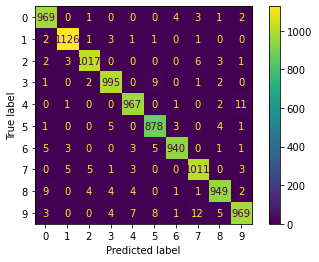

In [18]:
# Analyze the results
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

logits = CNN().apply({'params': best_state.params}, test_ds['image'], is_training=False, rngs={'dropout': random.PRNGKey(2)})
predicted = jnp.argmax(logits, -1)

print(
    f"Classification report:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
)

class_names = range(10)

# Confusion matrix
cm = confusion_matrix(y_test, predicted, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
disp.plot()
plt.show()

In [19]:
import jax
import jax.numpy as jnp                # JAX NumPy
from jax import random

from flax import linen as nn           # The Linen API
from flax.training import train_state  # Useful dataclass to keep train state

import numpy as np                     # Ordinary NumPy
import optax                           # Optimizers

from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt

# Import database
import idx2numpy

file_X_train = 'mnist/train-images.idx3-ubyte' 
file_y_train = 'mnist/train-labels.idx1-ubyte'
file_X_test = 'mnist/t10k-images.idx3-ubyte' 
file_y_test = 'mnist/t10k-labels.idx1-ubyte' 

X_train = idx2numpy.convert_from_file(file_X_train)
y_train = idx2numpy.convert_from_file(file_y_train)
X_test = idx2numpy.convert_from_file(file_X_test)
y_test = idx2numpy.convert_from_file(file_y_test)

# Information about the dataset
npoints_train, xres, yres = X_train.shape
npoints_test, _, _ = X_test.shape
print('The number of data points in the training dataset is {:d}'.format(npoints_train))
print('The number of data points in the test dataset is {:d}'.format(npoints_test))
print('The image resolution is {:d}x{:d}'.format(xres, yres))

# Prepare datasets
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Create datasets
def get_datasets(X_train, X_test, y_train, y_test):

  train_ds = {'image': jnp.float32(X_train), 'label': y_train}
  test_ds = {'image': jnp.float32(X_test), 'label': y_test}
    
  return train_ds, test_ds

train_ds, test_ds = get_datasets(X_train, X_test, y_train, y_test)

# Model
class CNN(nn.Module):
  """A simple CNN model."""

  @nn.compact
  def __call__(self, x, is_training):
    dropout_rng = self.make_rng('dropout')
    x = nn.Conv(features=32, kernel_size=(3, 3), padding='same')(x)
    x = nn.relu(x)
    x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=64, kernel_size=(3, 3), padding='same')(x)
    x = nn.relu(x)
    x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=128, kernel_size=(3, 3), padding='same')(x)
    x = nn.relu(x)
    x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Dropout(0.2, deterministic=not is_training)(x)
    x = x.reshape((x.shape[0], -1))  # flatten
    x = nn.Dense(features=256)(x)
    x = nn.relu(x)
    x = nn.Dense(features=10)(x)
    x = nn.log_softmax(x)
    
    return x

# Loss
def cross_entropy_loss(*, logits, labels):
  one_hot_labels = jax.nn.one_hot(labels, num_classes=10)
  return -jnp.mean(jnp.sum(one_hot_labels * logits, axis=-1))

# Metric
def compute_metrics(*, logits, labels):
  loss = cross_entropy_loss(logits=logits, labels=labels)
  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  metrics = {
      'loss': loss,
      'accuracy': accuracy,
  }
  return metrics

# Training state
def create_train_state(rng, learning_rate):
  """Creates initial `TrainState`."""
  cnn = CNN()
  params = cnn.init(rng, jnp.ones([1, xres, yres, 1]), is_training=True)['params']
  tx = optax.adam(learning_rate)
  return train_state.TrainState.create(
      apply_fn=cnn.apply, params=params, tx=tx)

# Training step
@jax.jit
def train_step(state, batch):
  """Train for a single step."""
  def loss_fn(params):
    logits = CNN().apply({'params': params}, batch['image'], is_training=True, rngs={'dropout': random.PRNGKey(2)})
    loss = cross_entropy_loss(logits=logits, labels=batch['label'])
    return loss, logits
  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (_, logits), grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  metrics = compute_metrics(logits=logits, labels=batch['label'])
  return state, metrics

# Evaluation step
@jax.jit
def eval_step(params, batch):
  logits = CNN().apply({'params': params}, batch['image'], is_training=False, rngs={'dropout': random.PRNGKey(2)})
  return compute_metrics(logits=logits, labels=batch['label'])

# Train function
def train_epoch(state, train_ds, batch_size, epoch, rng):
  """Train for a single epoch."""
  train_ds_size = len(train_ds['image'])
  steps_per_epoch = train_ds_size // batch_size

  perms = jax.random.permutation(rng, train_ds_size)
  perms = perms[:steps_per_epoch * batch_size]  # skip incomplete batch
  perms = perms.reshape((steps_per_epoch, batch_size))
  batch_metrics = []
  for perm in perms:
    batch = {k: v[perm, ...] for k, v in train_ds.items()}
    state, metrics = train_step(state, batch)
    batch_metrics.append(metrics)

  # compute mean of metrics across each batch in epoch.
  batch_metrics_np = jax.device_get(batch_metrics)
  epoch_metrics_np = {
      k: np.mean([metrics[k] for metrics in batch_metrics_np])
      for k in batch_metrics_np[0]}

  print('train epoch: %d, loss: %.4f, accuracy: %.2f' % (
      epoch, epoch_metrics_np['loss'], epoch_metrics_np['accuracy'] * 100))

  return state

# Evaluation function
def eval_model(params, test_ds):
  metrics = eval_step(params, test_ds)
  metrics = jax.device_get(metrics)
  summary = jax.tree_map(lambda x: x.item(), metrics)
  return summary['loss'], summary['accuracy']

# Seed randomness
rng = jax.random.PRNGKey(0)
rng, *init_rng = jax.random.split(rng, 3)

# Initialize train state
learning_rate = 1e-3

state = create_train_state({'params': init_rng[0], 'dropout': init_rng[1]}, learning_rate)
del init_rng  # Must not be used anymore.

# Train and evaluate
num_epochs = 200
batch_size = 32
best_state = None
best_test_accuracy = 0
patience = 10
n_steps = 0

for epoch in range(1, num_epochs + 1):
  # Use a separate PRNG key to permute image data during shuffling
  rng, input_rng = jax.random.split(rng)
  # Run an optimization step over a training batch
  state = train_epoch(state, train_ds, batch_size, epoch, input_rng)
  # Evaluate on the test set after each training epoch
  test_loss, test_accuracy = eval_model(state.params, test_ds)
  print(' test epoch: %d, loss: %.2f, accuracy: %.2f' % (
      epoch, test_loss, test_accuracy * 100))
  if test_accuracy > best_test_accuracy:
        best_state = state
        best_test_accuracy = test_accuracy
        n_steps = 0
  else:
    n_steps += 1
  if n_steps > patience - 1:
    break

The number of data points in the training dataset is 60000
The number of data points in the test dataset is 10000
The image resolution is 28x28
train epoch: 1, loss: 0.6832, accuracy: 93.00
 test epoch: 1, loss: 0.10, accuracy: 97.05
train epoch: 2, loss: 0.0974, accuracy: 97.20
 test epoch: 2, loss: 0.07, accuracy: 97.91
train epoch: 3, loss: 0.0792, accuracy: 97.75
 test epoch: 3, loss: 0.06, accuracy: 98.23
train epoch: 4, loss: 0.0679, accuracy: 98.04
 test epoch: 4, loss: 0.05, accuracy: 98.69
train epoch: 5, loss: 0.0597, accuracy: 98.29
 test epoch: 5, loss: 0.05, accuracy: 98.56
train epoch: 6, loss: 0.0539, accuracy: 98.51
 test epoch: 6, loss: 0.06, accuracy: 98.47
train epoch: 7, loss: 0.0518, accuracy: 98.57
 test epoch: 7, loss: 0.05, accuracy: 98.75
train epoch: 8, loss: 0.0473, accuracy: 98.72
 test epoch: 8, loss: 0.05, accuracy: 98.70
train epoch: 9, loss: 0.0456, accuracy: 98.79
 test epoch: 9, loss: 0.06, accuracy: 98.39
train epoch: 10, loss: 0.0414, accuracy: 98.97

Classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.99      0.99      1135
           2       1.00      0.99      1.00      1032
           3       0.98      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000




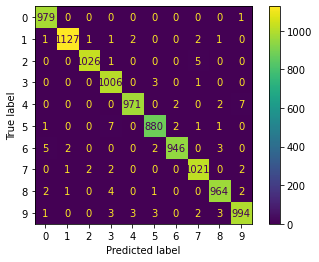

In [20]:
# Analyze the results
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

logits = CNN().apply({'params': best_state.params}, test_ds['image'], is_training=False, rngs={'dropout': random.PRNGKey(2)})
predicted = jnp.argmax(logits, -1)

print(
    f"Classification report:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
)

class_names = range(10)

# Confusion matrix
cm = confusion_matrix(y_test, predicted, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
disp.plot()
plt.show()

In total 86 mistakes out of 10000 images


100%|███████████████████████████████████████████████████████████████████████████████████| 86/86 [07:48<00:00,  5.44s/it]


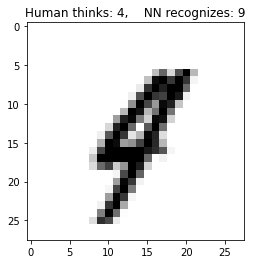

In [21]:
# Error analyses
from tqdm import tqdm

err = []
for i in range(len(y_test)):
  if y_test[i] != predicted[i]:
    err.append(i)

print('In total {:d} mistakes out of {:d} images'.format(len(err), len(y_test)))

for i in tqdm(range(len(err))):
  plt.imshow(X_test[err[i]], cmap=plt.cm.gray_r, interpolation="nearest")
  plt.title('Human thinks: {:},    NN recognizes: {:}'.format(y_test[err[i]], predicted[err[i]]))
  plt.savefig('./errors/{}.png'.format(err[i]), dpi=600)